In [17]:
import pandas as pd
import matplotlib.pyplot as plt
from Uma_fall_labels import search_csv_files
import math

In [18]:
files = search_csv_files('output')
data = pd.read_csv(files[0])

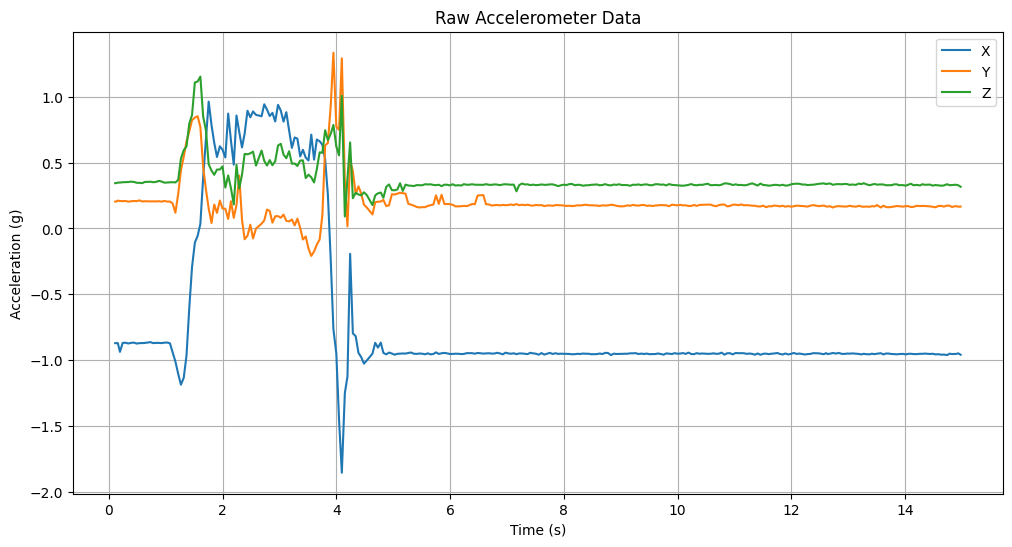

In [19]:
plt.figure(figsize=(12, 6))
plt.plot(data['TimeStamp'], data['Accelerometer: x-axis (g)'], label='X')
plt.plot(data['TimeStamp'], data['Accelerometer: y-axis (g)'], label='Y')
plt.plot(data['TimeStamp'], data['Accelerometer: z-axis (g)'], label='Z')
plt.title("Raw Accelerometer Data")
plt.xlabel("Time (s)")
plt.ylabel("Acceleration (g)")
plt.legend()
plt.grid()

plt.show()

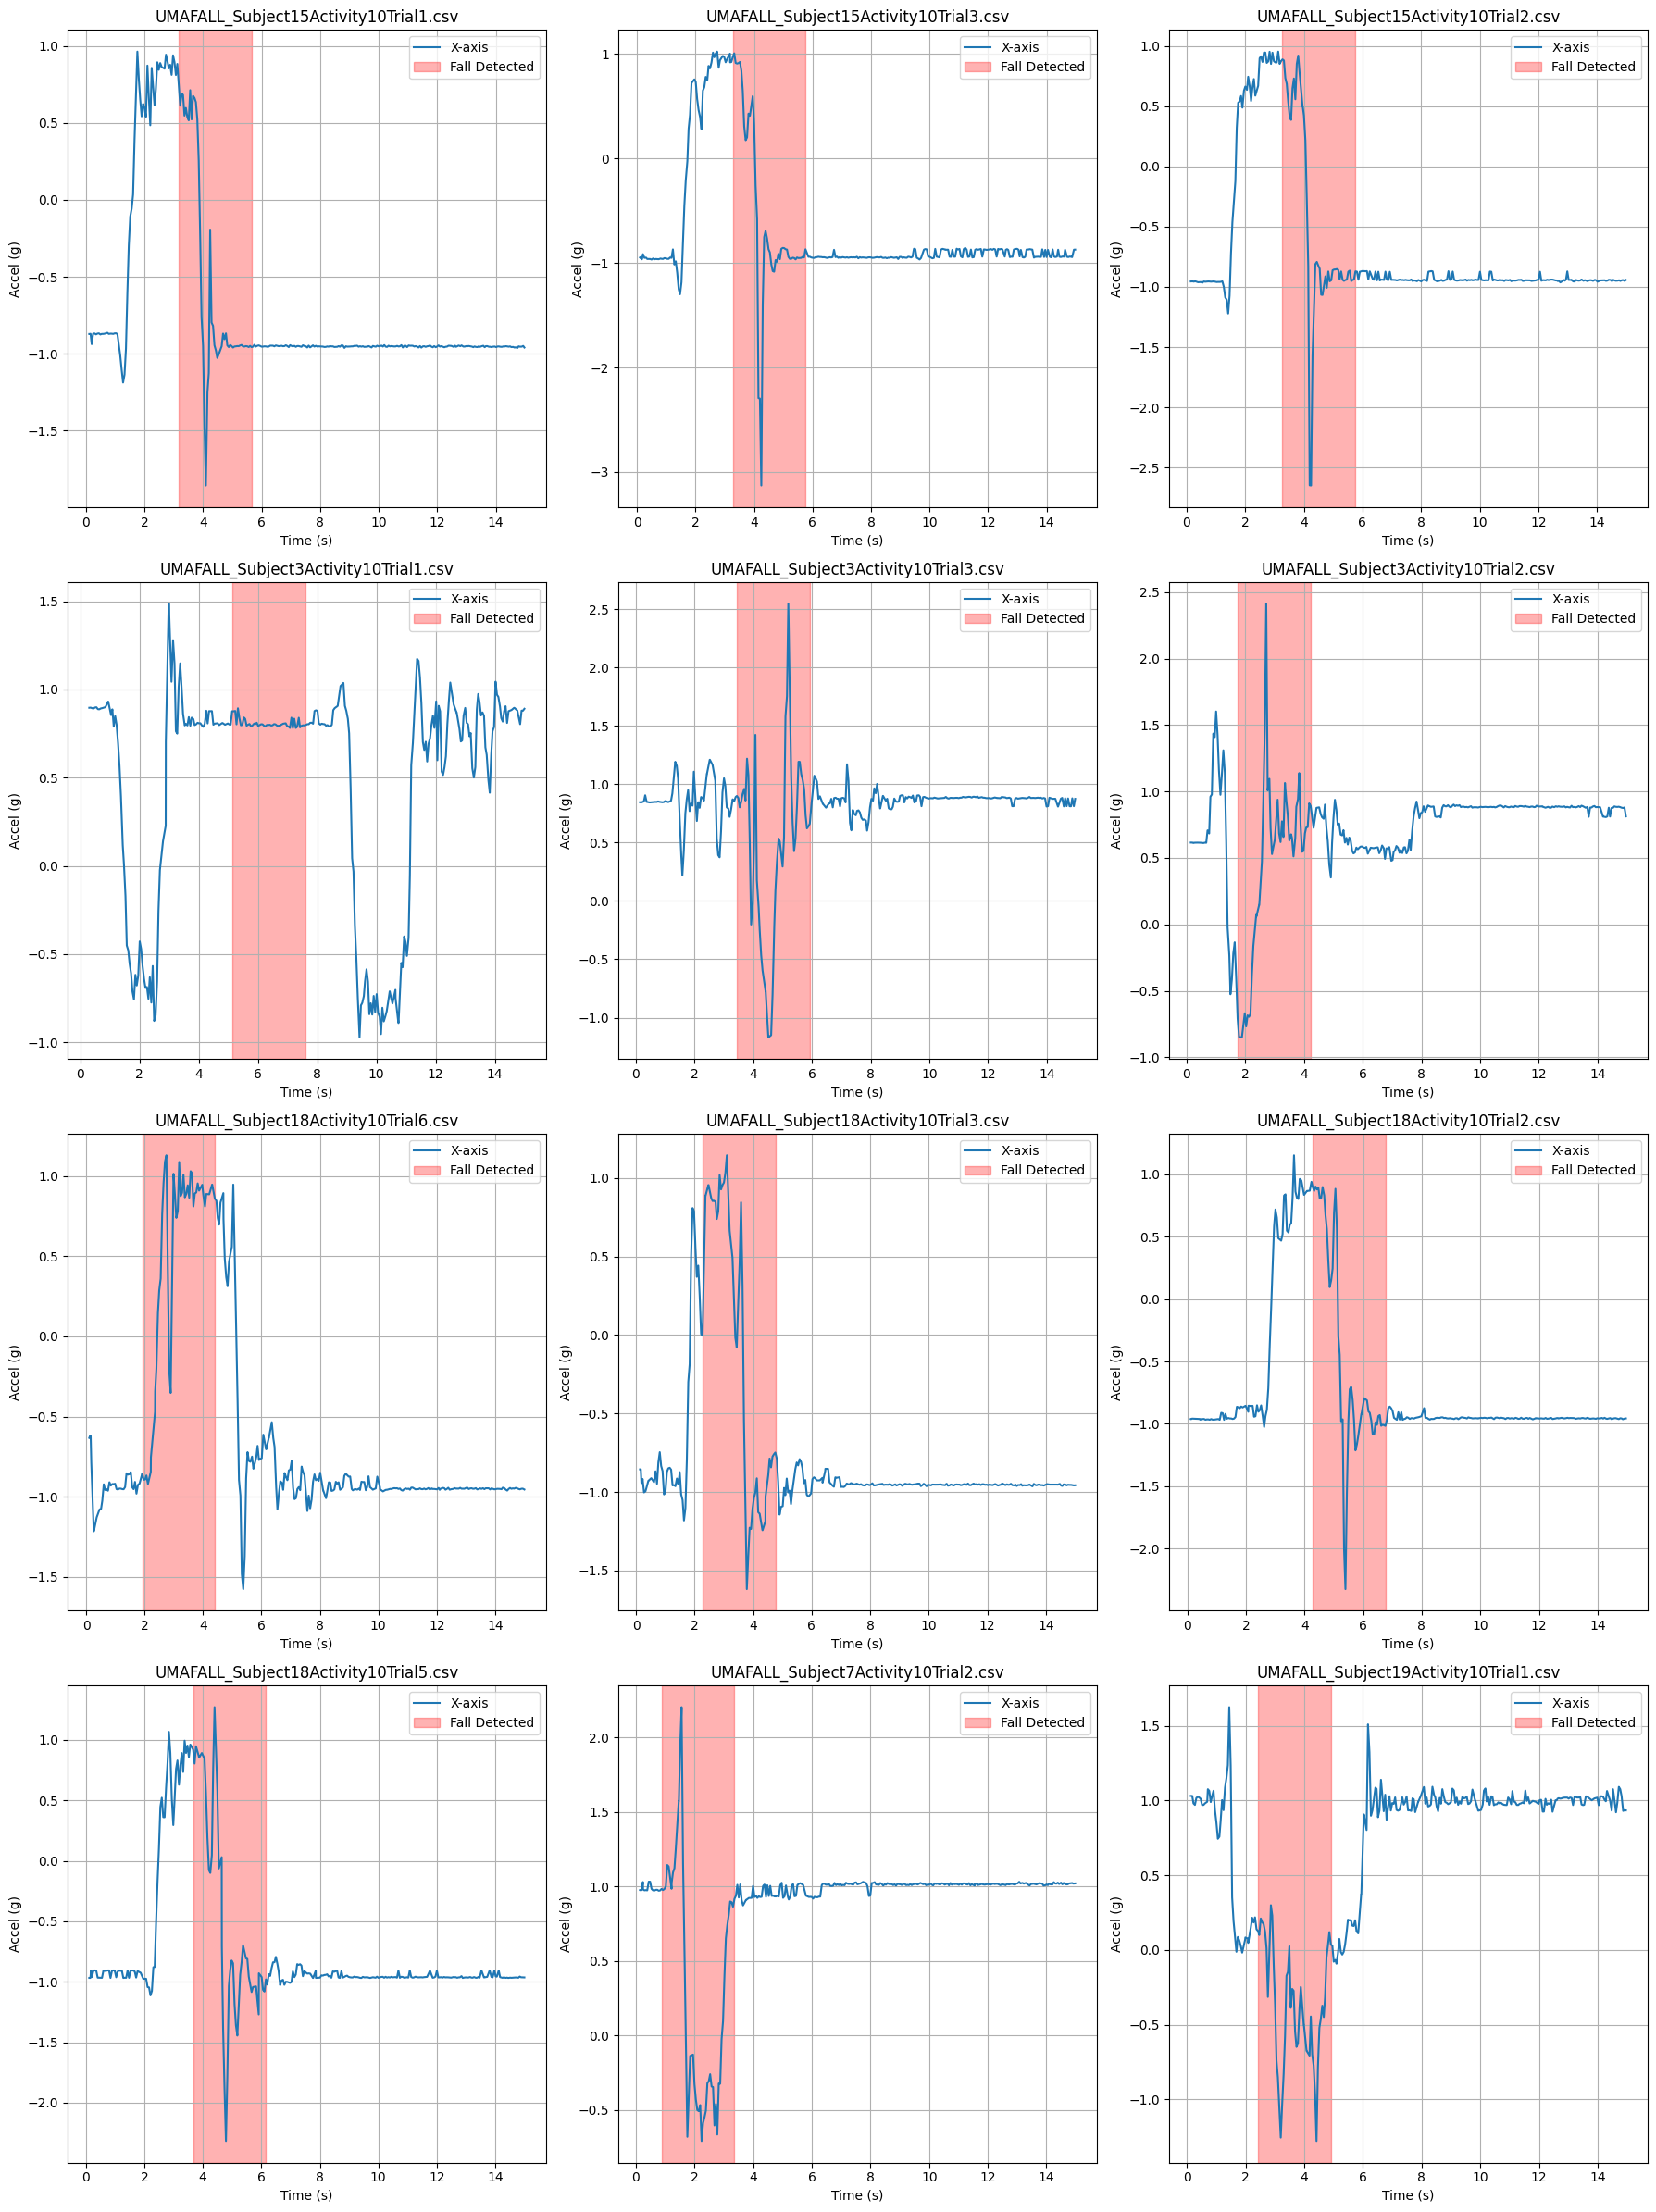

In [24]:
valid_files = []

# Pre-filter only files with at least one fall (Tag == 1)
for file_path in files:
    try:
        data = pd.read_csv(file_path)
        if 'Tag' in data.columns and data['Tag'].astype(str).str.contains("1").any():
            valid_files.append(file_path)
    except Exception as e:
        print(f"Error reading {file_path}: {e}")

# Plot settings
plots_per_row = 3
total_plots = len(valid_files)
rows = math.ceil(total_plots / plots_per_row)

# Create figure and axes
fig, axs = plt.subplots(rows, plots_per_row, figsize=(18, 6 * rows))
axs = axs.flatten()

for i, file_path in enumerate(valid_files):
    data = pd.read_csv(file_path)
    fall_indices = data[data['Tag'].astype(str) == "1"].index
    ax = axs[i]

    ax.plot(data['TimeStamp'], data['Accelerometer: x-axis (g)'], label='X-axis')
    ax.axvspan(data['TimeStamp'][fall_indices[0]], data['TimeStamp'][fall_indices[-1]], 
               color='red', alpha=0.3, label='Fall Detected')

    ax.set_title(f"{file_path.split('/')[-1]}")
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Accel (g)")
    ax.legend()
    ax.grid()

# Remove unused axes
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()
